# <div style = 'background:#0277BD; border:2; border-radius: 10px; font-size:150%; font-weight: bold;color:white'> <center> Drug Review Sentiment Analysis </div>

<img src="https://www.fda.gov/files/styles/main_image_1/public/How_to_Buy_Medicines_Safely_From_an_Online_Pharmacy_1600x900.png?itok=y5olqkV2" width="950" height="600" />

<a id = "table"></a>
# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 12px; line-height: 0.8;">Table of Contents</div></center>

### [**1. Introduction**](#title-one)
    
### [**2. Dataset**](#title-two) 

### [**3. Data Cleaning**](#title-three) 

### [**4. Exploratory Data Analysis**](#title-four)

### [**5. Text Preprocessing (NLP)**](#title-five)

### [**6. LightGBM Modeling**](#title-six) 

### [**7. Conclusions & Discussion**](#title-seven)

### [**8. Reference**](#title-eight)

<a id = "title-one"></a>
# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 12px; line-height: 0.6;">Introduction</div></center>

This is a pretty simple project. We have a dataset that provides patient reviews on specific drugs, which were obtained by crawling online pharmaceutical review sites. The objective is to distinguish a positive review from a negative one based on review text analysis. 

We will performance some exploratory data analysis to gain useful insights. Since we are dealing with patient review, we are interested in sentiment analysis. We will attempt to predict whether a review is positive or negative using sentiment analysis and a machine learning model, Light Gradient Boosting Machine (LightGBM).

<a id = "title-two"></a>
# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 12px; line-height: 0.6;">Dataset</div></center>

The Drug Review Dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29). This Dataset provides patient reviews on specific drugs along with related conditions. There are six features: 

- **drugName:** name of drug 
- **condition:** the condition the patient is suffering from
- **review:** patient review for the drug
- **rating:** 10-star rating for the drug, reflecting the overall patient satisfaction
- **date:** date of review entry 
- **usefulCount:** number of users who found the review useful

## Import Required Libraries

In [1]:
%matplotlib inline
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import ipywidgets as widgets
import pandas as pd 
import qgrid
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
plt.rc('axes', titlesize=18)     
plt.rc('axes', labelsize=14)   
plt.rc('xtick', labelsize=12)    
plt.rc('ytick', labelsize=12)    
plt.rc('legend', fontsize=12)    
plt.rc('font', size=13)          
import seaborn as sns
sns.set_style('darkgrid') 
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from textblob import TextBlob, Word
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, classification_report, f1_score
from lightgbm import LGBMModel,LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bensmacbookpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bensmacbookpro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/bensmacbookpro/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Read the Data

In [2]:
df_train = pd.read_csv("drugsComTrain_raw.tsv", sep='\t', parse_dates=["date"])
df_test = pd.read_csv("drugsComTest_raw.tsv", sep='\t', parse_dates=["date"]) 

In [3]:
# we'll combine the train and test datasets for now for preprocessing
data = pd.concat([df_train,df_test])

In [4]:
data.sample(20)

Unnamed: 0        drugName                       condition  \
34396        28784         Lexapro                      Depression   
120194      165597  Levonorgestrel         Emergency Contraception   
26359       131412     Generess Fe                   Birth Control   
52590       146287        Suboxone               Opiate Dependence   
143341       20752         Nucynta                            Pain   
42563        63827      Sertraline     Generalized Anxiety Disorde   
13934       121499     Venlafaxine        Major Depressive Disorde   
43471        47650      Tapentadol                            Pain   
9131         34909     Minocycline                            Acne   
150781       94532         Abilify                 Bipolar Disorde   
12816       173596   Brexpiprazole        Major Depressive Disorde   
159989      113825        Tegretol                        Epilepsy   
25069       101345           Aubra                   Birth Control   
59432        38801    Esomeprazole                            GERD   
55421       109136       Nexplanon                   Birth Control   
28737       223004         Topamax             Migraine Prevention   
35101       209898        VESIcare               Overactive Bladde   
151460        1334     Sumatriptan        Cyclic Vomiting Syndrome   
7896        178770         Victoza                Diabetes, Type 2   
97625       201393          Zoloft  Premenstrual Dysphoric Disorde   

                                                   review  rating       date  \
34396   "I have been taking Lexapro for more than four...     9.0 2010-02-01   
120194  "About a month ago me and my boyfriend had unp...     2.0 2017-05-07   
26359   "Been on this for a little under a year. I hav...     9.0 2014-01-22   
52590   "I was using 3-5 bags of heroin a day.  I got ...    10.0 2009-06-14   
143341  "My Pain Specialist prescribed me Nucynta four...     8.0 2010-05-08   
42563   "Have gone off and on this medicine a couple t...     8.0 2017-12-01   
13934   "I&#039;ve been on this drug for the past thre...     3.0 2015-12-01   
43471   "250mg once every 12hrs didn&#039;t do much fo...     3.0 2011-12-29   
9131    "I have had acne since I was 12 years old. My ...     4.0 2015-06-26   
150781  "Total Mania, could not sleep, monitored sleep...     1.0 2017-01-13   
12816   "Been on 1 mg for two weeks. Depression has li...     9.0 2017-07-10   
159989  "I had 1 seizure, 2 weeks after our son was bo...    10.0 2015-03-25   
25069   "So far so good. I&#039;m just on my first pac...     7.0 2016-09-03   
59432   "I used this product as a free sample and it w...    10.0 2015-08-17   
55421   "I can&#039;t tell you how great this has been...    10.0 2017-03-30   
28737   "Once I got past the side effects while titrat...     9.0 2009-01-27   
35101   "Been having cold like symptoms. Running nose,...     2.0 2015-10-14   
151460  "The best medication I have ever taken for my ...    10.0 2013-04-09   
7896    "The nausea, vomiting and massive diarrhea was...     1.0 2014-05-08   
97625   "Awful side effects! Caused me to feel very un...     1.0 2015-04-16   

        usefulCount  
34396            37  
120194           18  
26359            13  
52590            16  
143341          120  
42563             0  
13934             4  
43471             8  
9131              4  
150781           11  
12816            20  
159989           14  
25069             0  
59432             0  
55421             1  
28737            23  
35101            26  
151460            4  
7896             36  
97625            15

<a id = "title-three"></a>
# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 12px; line-height: 0.6;">Data Cleaning</div></center>

In [5]:
# let's take a quick look
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   215063 non-null  int64         
 1   drugName     215063 non-null  object        
 2   condition    213869 non-null  object        
 3   review       215063 non-null  object        
 4   rating       215063 non-null  float64       
 5   date         215063 non-null  datetime64[ns]
 6   usefulCount  215063 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 13.1+ MB


In [6]:
# delete the first column 'Unnamed: 0', which is useless for the analsysis
data = data.drop(['Unnamed: 0'], axis = 1)

In [7]:
# fix datatype
data['rating'] = data['rating'].astype(int)

In [8]:
# check the % of null values in each columns
data.isnull().sum()/data.shape[0]*100

drugName       0.000000
condition      0.555186
review         0.000000
rating         0.000000
date           0.000000
usefulCount    0.000000
dtype: float64

In [9]:
# note only 'condition' has null values and they're only ~ 0.56%
# we'll delete the rows with null values
data = data.dropna()

# check again to confirm
data.isna().sum() 

drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [10]:
# delete the review with 0 usefulCount
data = data.loc[data['usefulCount']!=0]

In [11]:
# some rows list "users found this review is helpful" as a condtion
# those are likely erros during web scraping and we'll delete those rows 
data = data[data['condition'].str.contains('users found this') == False]

<a id = "title-four"></a>
# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 12px; line-height: 0.6;">Exploratory Data Analysis</div></center>

### How many conditions?

In [12]:
data['condition'].nunique()

809

### How many drugs?

In [13]:
data['drugName'].nunique()

3489

### Top 10 conditions that patients suffer from

Text(0, 0.5, 'Number of Reviews')

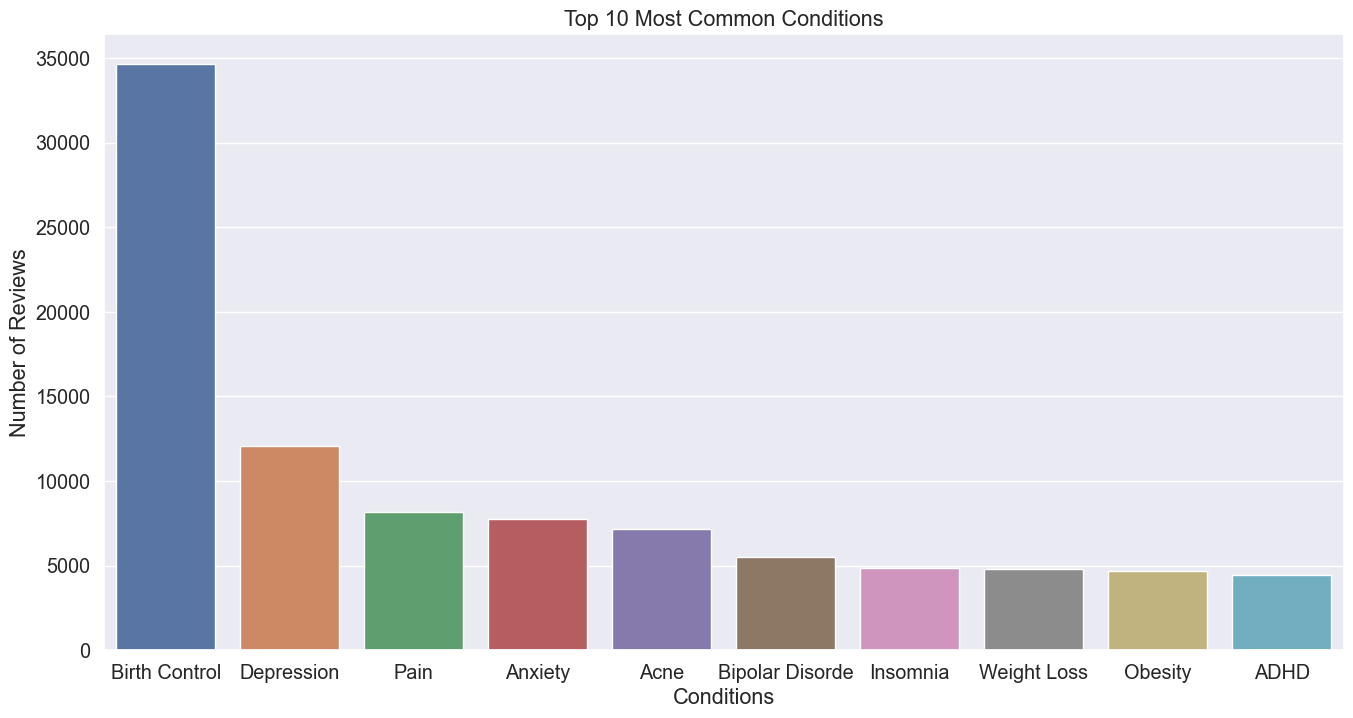

In [14]:
conditions = dict(data['condition'].value_counts())
top_conditions = list(conditions.keys())[0:10]
num_reviews = list(conditions.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [16, 8]

sns_ = sns.barplot(x = top_conditions, y = num_reviews)
sns_.set_title("Top 10 Most Common Conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Number of Reviews")

### Take Depression as an example: 
### Top 10 drugs

Text(0.5, 1.0, 'Top 10 Drugs Used for Depression')

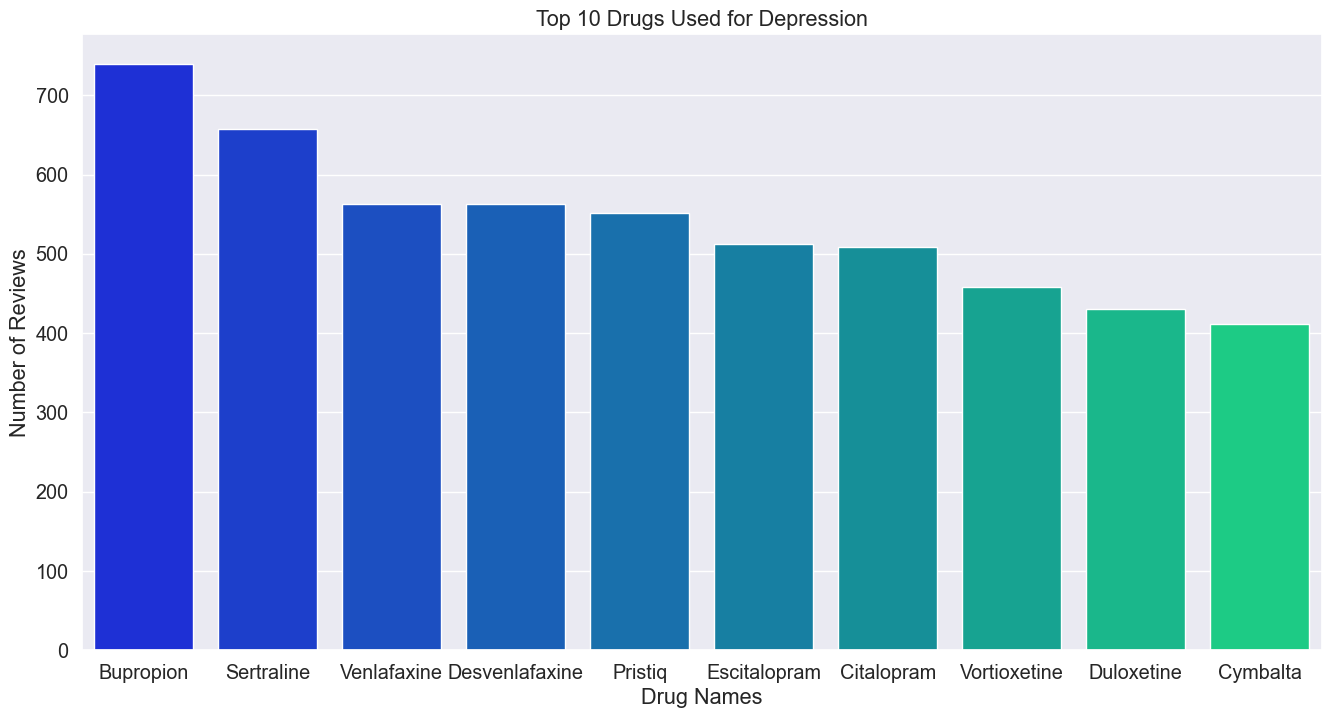

In [15]:
depression = data[data['condition'] == 'Depression']['drugName'].value_counts()[0: 10]
# sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = depression.index, y = depression.values, palette = 'winter')
sns_.set_xlabel('Drug Names')
sns_.set_ylabel("Number of Reviews")
sns_.set_title("Top 10 Drugs Used for Depression")
# plt.setp(sns_.get_xticklabels(), rotation = 90);

## This can be a very useful tool!!

One can easily search for the best **drugs** for a given **condition** and read some useful reviews.👇

In [16]:
table = qgrid.show_grid(data)
table

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

<a id = "title-five"></a>
# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 12px; line-height: 0.6;">Text Preprocessing (NLP)</div></center>

### Making the dataset a bit smaller for text preprocessing
We'll only focus on **review** and **rating** for the following analysis. 

In [17]:
data_nlp = data[["review", "rating"]]

Create another column (**Neg_Pos**) and group reviews as Positive (1) and Negative (0) based on ratings. 

|rating|Neg_Pos||
|----|----|----|
|rating >= 8|1|
|3 < rating < 8|neutral (removed from further analysis)|
|rating <= 3|0|

In [18]:
# only keep reviews with ratings <= 3 or >= 8
data_nlp = data_nlp.iloc[[x[0] or x[1] for x in list(zip((data_nlp['rating'] <= 3), (data_nlp['rating'] >= 8)))], :]

# reviews with high ratings (8, 9, 10) are grouped as Positive (1) and low ratings (1, 2, 3) as Negative (0)
data_nlp['Neg_Pos'] = data_nlp['rating'].apply(lambda x: 0 if x in [1,2,3] else 1)

In [19]:
# this is the dataset we'll use
data_nlp.sample(50)

review  rating  Neg_Pos
58376   "This was for a bowel prep. Liquids 2 days bef...       1        0
153832  "This implant destroyed the last 4 months of m...       1        0
68943   "I was on Phentermine 30 mg for about a month ...       8        1
89874   "I have had acid reflux for over 5 years and w...       8        1
51138   "I had horrible insomia and this took care of ...      10        1
142816  "Reported my first experience which was excell...       9        1
131398  "I was given Reglan pre surgery last month. My...       1        0
18026   "I&#039;ve been taking Avinza for a few years ...       9        1
127157  "After taking it for 4 days it made me sick to...       1        0
54207   "The constant stress that I was under in my ma...      10        1
84093   "It works I went to the er and I was told to t...      10        1
2399    "This drug has been a lifesaver to me. It&#039...       9        1
81468   "This medicine works well. I think it works be...       8        1
23143   "I&#039;ve been on 200mg Zoloft daily for the ...      10        1
31757   "Have had intractable insomnia since having ne...       1        0
4661    "I have tried many bipolar, mania medicines wi...      10        1
25444   "Have been on these for 3 days.  Having really...       8        1
58079   "I had been on Zanex to help me sleep. Usually...       1        0
151418  "Worked well and fast, easy to use, no stank, ...       9        1
109344  "I was given a depo provera shot after an essu...       1        0
49707   "Severe, chronic pain with Fractuted \r\n L3 v...       1        0
20131   "I started taking Valtrex 2 days after the ras...      10        1
68582   "Hello all,\r\r\n\r\r\nI never really write re...       3        0
88394   "Ive been on losartin for 4 years 2.5mg after ...      10        1
158887  "I&rsquo;m 47 and and have been an RN for over...       1        0
69941   "I started using Celexa in 2005 following the ...       8        1
43839   "I have been on Orencia for 3.5 years and diag...      10        1
43499   "I had bursitis in my hip and could hardly wal...      10        1
77114   "I took plan b about a month and a half ago af...       9        1
34885   "I am the first one in the State of New Jersey...      10        1
2160    "I got Kyleena put in on 8/31, it&#039;s been ...       8        1
132448  "8 week post treatment, Hep C virus free after...      10        1
100978  "I have been on 4 Norco 10 mg. for a few years...       8        1
135668  "Could not hold water down and had heaves all ...      10        1
62918   "Not bad. forgot the crystal light, and after ...       9        1
6219    "Took 25mg and thought I was going to die. Wor...       1        0
121191  "This is my 3rd time using these pills.  The f...      10        1
14758   "40 yrs old &amp; last year tried the progeste...       1        0
53332   "Taking 2.5mg per day (that&#039;s half a 5mg ...       9        1
136003  "No issues but worried about recent articles o...      10        1
93955   "I had my gullbladder removed in 2004, resulti...      10        1
100301  "I started taking this medication when I was i...      10        1
151187  "I have had the Mirena for about 4 and a half ...       9        1
13571   "It has been great, but I am to relaxed and ha...       9        1
13889   "I am a veteran and also retired from the Dept...       2        0
130290  "Tremors, anxiety, panic attacks, brainfog, in...       1        0
132821  "I was 90% covered. Dermatologist took one loo...       9        1
7646    "I was recently given valium with methadone fo...       9        1
105697  "I had the nexplanon inserted because the IUD ...       3        0
592     "Cymbalta 120mg for 4 months\r\nGood:\r\n- sli...       8        1

## Now we are ready to do some text preprocessing.
- Converting to lowercase
- Removing: 
  - lowercase
  - numbers
  - punctuations except "!"
  - html tags
  - non ASCII characters
  - all special characters
  - leading and trailing white spaces
- Replacing multiple spaces with single space
- Lemmatization

#### Converting to lowercase

In [20]:
data_nlp['review_cleaned'] = data_nlp['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#### Removing numbers

In [21]:
data_nlp['review_cleaned'] = data_nlp['review_cleaned'].str.replace('[\d+]', '')

#### Removing punctuations except "!"

In [22]:
data_nlp['review_cleaned'] = data_nlp['review_cleaned'].str.replace('[\.;:,\?\"\'\/]', '')

#### Removing stopwords

In [23]:
stop_words = stopwords.words('english')
data_nlp['review_cleaned'] = data_nlp['review_cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

#### Removing html tags

In [24]:
def resub(review):
    review = BeautifulSoup(review,'lxml').text
    return review

In [25]:
data_nlp['review_cleaned'] = data_nlp['review_cleaned'].apply(resub)

#### Removing all the non ASCII characters

In [26]:
data_nlp['review_cleaned'] = data_nlp['review_cleaned'].str.replace('[^\x00-\x7F]', '')

#### Removing all special characters

In [27]:
data_nlp['review_cleaned'] = data_nlp['review_cleaned'].str.replace('[^\w\d\s]', '')

#### Removing the leading and trailing white spaces

In [28]:
data_nlp['review_cleaned'] = data_nlp['review_cleaned'].str.replace('^\s+|\s+?$', '')

#### Replacing multiple spaces with single space

In [29]:
data_nlp['review_cleaned'] = data_nlp['review_cleaned'].str.replace('\s+', ' ')

#### Lemmatization

In [30]:
data_nlp['review_cleaned'] = data_nlp['review_cleaned'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [31]:
data_nlp.sample(20)

review  rating  Neg_Pos  \
158891  "This was the very first birth control brand I...       9        1   
109990  "My son switched from Risperidone to Vraylar, ...       9        1   
98193   "My husband had 2 treatments, by the 3rd sched...       1        0   
141227  "This is the first and last time I will take T...       1        0   
123871  "I have been taking one 2 mg clonidine twice a...       9        1   
87232   "I lost my mom at the age of 20, I am now 24 a...      10        1   
50677   "I have had insomnia and chronic pain for 24 y...       9        1   
35417   "Love it! The first two weeks were horrible an...       8        1   
19067   "So I took this after a panic attack over pre ...      10        1   
67887   "This medicine has given me horrible headaches...       1        0   
158001  "I have been suffering from recurrent uti&#039...      10        1   
143871  "I have been on Victoza since 5-9-14 started w...       9        1   
83469   "I have been on xanax since my first attack in...      10        1   
16297   "Made me feel like I was floating. Lasted 12-1...       2        0   
73327   "Robaxin helped me for the first couple of wee...       2        0   
151438  "After 1 month of losing my girlfriend and her...       8        1   
145694  "Fourteen years on Ultram, initially prescribe...      10        1   
33655   "Wow. It worked great. So easy to use and my k...      10        1   
24302   "I had IUD inserted Dec. 2016. I found out I w...       1        0   
144018  "I was previously on Loestrin FE for about 2 y...       1        0   

                                           review_cleaned  
158891  first birth control brand ive taken happy didn...  
109990  son switched risperidone vraylar terrific deci...  
98193   husband treatment rd scheduled appt died husba...  
141227  first last time take tamiflu made feel much wo...  
123871  taking one mg clonidine twice day opiate withd...  
87232   lost mom age zoloft mg past year cant believe ...  
50677   insomnia chronic pain year ive seen every spec...  
35417   love it first two week horrible felt like flu ...  
19067   took panic attack pre ejaculate tear purchasin...  
67887   medicine given horrible headache lost lot hair...  
158001  suffering recurrent utis year cystoscopes blad...  
143871  victoza since started noticed reading medicine...  
83469   xanax since first attack mid late s im first t...  
16297   made feel like floating lasted hour dose stop ...  
73327   robaxin helped first couple week stopped using...  
151438  month losing girlfriend mom horrible head coll...  
145694  fourteen year ultram initially prescribed migr...  
33655   wow worked great easy use kid hair looked smel...  
24302   iud inserted dec found pregnant april didnt ex...  
144018  previously loestrin fe year side effect medica...

## World Cloud

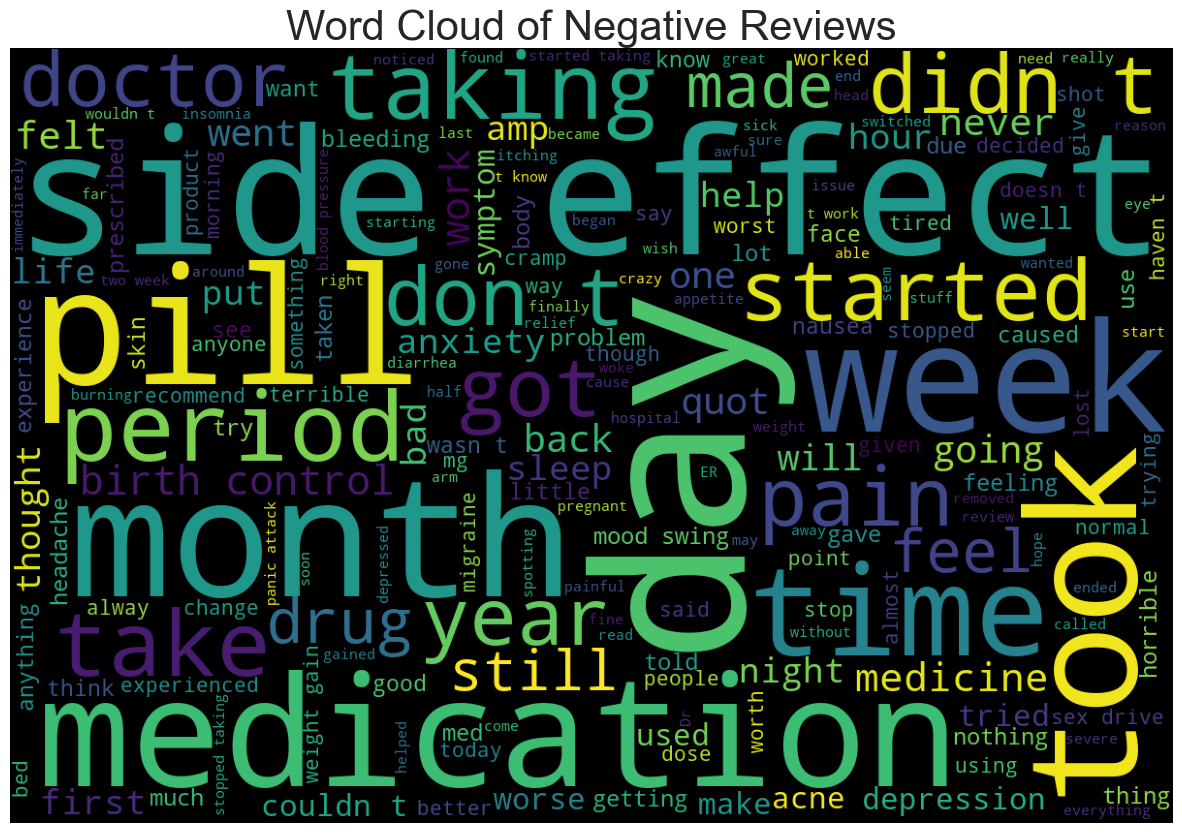

In [32]:
neg_word = " ".join([text for text in data_nlp['review'][data_nlp['Neg_Pos'] == 0]])

stopwords1 = set(STOPWORDS)
stopwords1 = stopwords1.union(["ha", "thi", "now", "onli", "im", "becaus", "wa", "ve", "even", "go", "realli", "abl", "s", "m"])
wordcloud = WordCloud(stopwords = stopwords1, width = 1200, height = 800).generate(neg_word)
                               
plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Negative Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

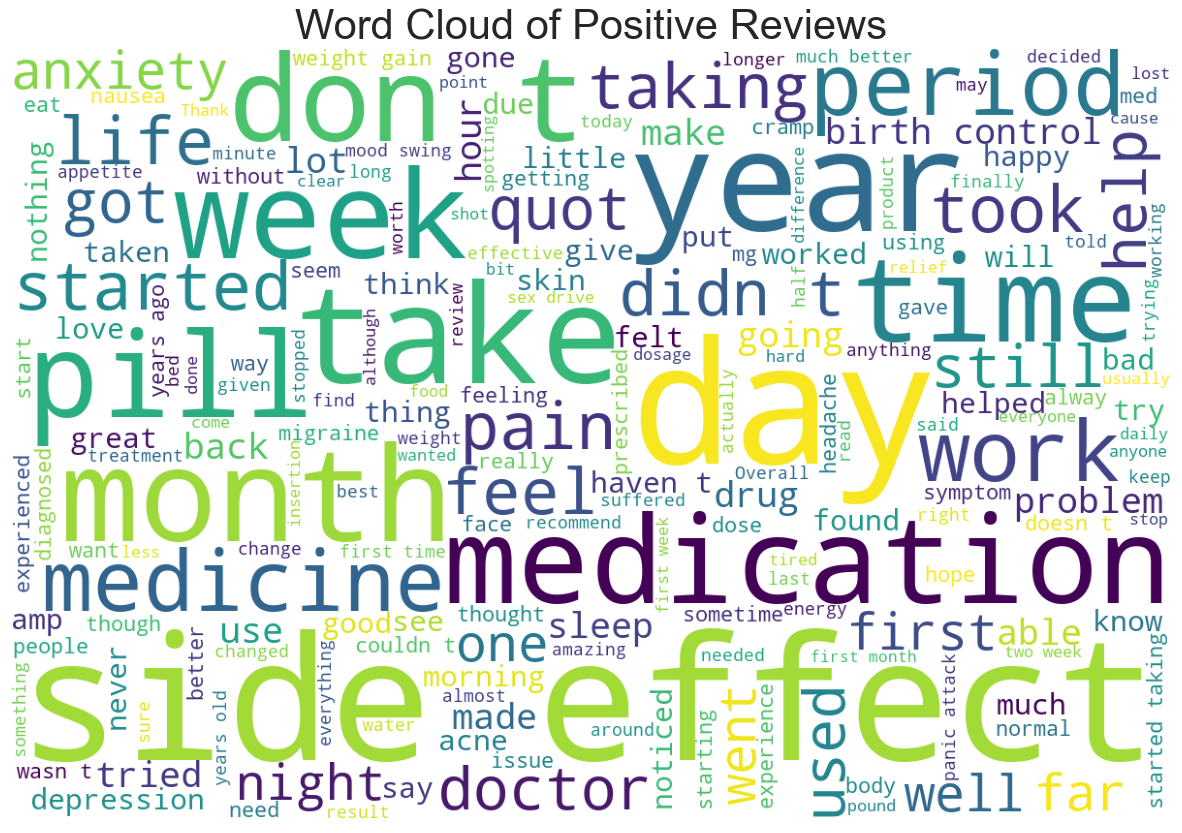

In [33]:
pos_word = " ".join([text for text in data_nlp['review'][data_nlp['Neg_Pos'] == 1]])

stopwords1 = set(STOPWORDS)
stopwords1 = stopwords1.union(["ha", "thi", "now", "onli", "im", "becaus", "wa", "ve", "even", "go", "realli", "abl", "s", "m"])
wordcloud = WordCloud(background_color = 'white', stopwords = stopwords1, width = 1200, height = 800).generate(pos_word)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Positive Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

## Sentiment analysis using TextBlob
TextBlob is an easy-to-use Natural Language Processing library written on top of NLTK. The `sentiment.polarity` ranges from -1 to +1. 

We'll see if we can predict a patient's rating (positive or negative) based on the sentiment polarity score. 

In [34]:
# a helper function to calculate the sentiment polalrity score for reviews
def sentiment(reviews):
    polar = []
    for review in reviews:
        analysis = TextBlob(review)
        polar.append(analysis.sentiment.polarity)
    return polar

# add a new column "sentiment_score"
data_nlp['sentiment_score'] = sentiment(data_nlp['review_cleaned'])

In [35]:
# lable it as 0 if the sentiment score is negative and 1 if positive
data_nlp['sentiment'] = data_nlp['sentiment_score'].apply(lambda x: 1 if x > 0 else 0 if (x <0) else "neutral")

In [36]:
data_nlp.sample(20)

review  rating  Neg_Pos  \
5733    "My son (6yrs) is on Focalin in the morning an...       1        0   
66156   "I have had a spastic colon for over fifty yea...       9        1   
47895   "Struggled with acne for years, and this has h...      10        1   
107116  "I have to be on it for 2 months due to surger...       8        1   
160300  "Modafinil gave me no relief from my day time ...       1        0   
58486   "This is my first month taking it. My skin act...       8        1   
16332   "After taking the 2nd pill I developed raised ...       1        0   
49677   "I&#039;ve taken One Nexium 40mg for 13 years ...      10        1   
53475   "I have been on this medication for 3 months n...       8        1   
121211  "I&#039;ve been on this for a little over a ye...      10        1   
50866   "I&#039;ve read almost every comment on this m...       8        1   
67883   "This medicine has been life changing. It is t...       9        1   
139643  "I was on other proton pump inhibitors but had...      10        1   
90473   "Great medication for breakthrough pain. Hate ...       9        1   
13608   "Since I&#039;ve been on the pill, my periods ...       8        1   
103505  "I&#039;m an undercover agent and was dealing ...       9        1   
13713   "Plaquenil has given me back my quality of lif...      10        1   
53439   "I am 42 years old. I have uterine fibroids wh...       9        1   
19050   "I had the depo injection for 8 years and my d...      10        1   
41470   "June 23, Dr. prescribed 20 mg. of Celexa for ...      10        1   

                                           review_cleaned  sentiment_score  \
5733    son yr focalin morning tenex late afternoon pu...        -0.014286   
66156   spastic colon fifty year product one provided ...         0.500000   
47895   struggled acne year honestly miracle worker iv...         0.214181   
107116  month due surgery chronic bladder infectionwom...         0.125000   
160300  modafinil gave relief day time sleepiness medi...        -0.050000   
58486   first month taking skin actually look clearer ...        -0.070052   
16332   taking nd pill developed raised red welt neck ...        -0.003030   
49677   ive taken one nexium mg year helpful could eat...        -0.350000   
53475   medication month mainly taking reduce pm sympt...         0.016667   
121211  ive little year it came market summer problem ...         0.142500   
50866   ive read almost every comment medicine anyone ...        -0.236905   
67883   medicine life changing medication found manage...         0.000000   
139643  proton pump inhibitor constant headache using ...         0.400000   
90473   great medication breakthrough pain hate consti...         0.162500   
13608   since ive pill period become extremely regular...         0.043750   
103505  im undercover agent dealing lot stress stress ...         0.190000   
13713   plaquenil given back quality life think ive ye...         0.037500   
53439   year old uterine fibroid past year caused exce...         0.100000   
19050   depo injection year doctor made stop even thou...         0.094156   
41470   june dr prescribed mg celexa social anxiety wo...         0.066667   

       sentiment  
5733           0  
66156          1  
47895          1  
107116         1  
160300         0  
58486          0  
16332          0  
49677          0  
53475          1  
121211         1  
50866          0  
67883    neutral  
139643         1  
90473          1  
13608          1  
103505         1  
13713          1  
53439          1  
19050          1  
41470          1

Now let's compare the sentiment analysis (0 or 1) with the rating (0 or 1) to see the **accuracy.** 

In [37]:
(data_nlp["Neg_Pos"] == data_nlp["sentiment"]).sum()/(data_nlp.shape[0]- (data_nlp["sentiment"] =="neutral").sum())

0.7129650521460088

A **71%** accuracy is not impressive. Next we'll use the **LightGBM** model to predict the rating (positive or negative) based on reviews. 

<a id = "title-six"></a>
# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 12px; line-height: 0.6;">LightGBM Modeling</div></center>

**LightGBM** is a gradient boosting framework based on decision trees to increases the efficiency of the model and reduces memory usage. 

In [38]:
# split the dataset into train (70%) and test (30%) sets 
X_train, X_test, y_train, y_test = train_test_split(data_nlp['review_cleaned'], data_nlp['Neg_Pos'], 
                                       test_size=0.3, random_state=42)

In [39]:
# we use TfidfVectorizer instead of CountVectorizer to also consider the word importance in the whole corpus
tv = TfidfVectorizer(ngram_range = (1,3),
                    sublinear_tf = True,
                    max_features = 40000)

In [40]:
train_tv = tv.fit_transform(X_train)
test_tv = tv.transform(X_test)

In [41]:
clf = LGBMClassifier(
        n_estimators=5000,
        learning_rate=0.20,
        num_leaves=20,
        subsample=.9,
        max_depth=6,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
model = clf.fit(train_tv, y_train)

In [42]:
y_pred = model.predict(test_tv)

In [43]:
accuracy_score(y_test, y_pred).round(2)

0.95

In [44]:
precision_score(y_test, y_pred).round(2)

0.96

In [45]:
recall_score(y_test, y_pred).round(2)

0.97

In [46]:
f1_score(y_test, y_pred).round(2)

0.96

In [47]:
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")

Confusion Matrix: 
 [[11492  1706]
 [  971 36471]]


In [48]:
print(f" Classification Report: \n {classification_report(y_test, y_pred)}")

 Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.87      0.90     13198
           1       0.96      0.97      0.96     37442

    accuracy                           0.95     50640
   macro avg       0.94      0.92      0.93     50640
weighted avg       0.95      0.95      0.95     50640



<a id = "title-seven"></a>
# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 12px; line-height: 0.6;">Conclusions & Discussion</div></center>
    
- The Drug Review dataset can be used to build a useful tool. One can easily search for the best drugs for a given condition and read some useful reviews.
    
    
- Using the sentiment score to predict rating (positive or negative) only resulted in 71% accuracy, suggesting room for improvement. It might be helpful to remove sentences with neutral sentiment and only run sentiment analysis on the polar sentences. 
    
    
- The LightGBM model predicts whether a review is positive or negative with a 95% accuracy! More hyperparameter tuning may further improve its performance. We can see some imbalanced classification, which is due to unbalanced positive (1) and negative (0) reviews in the dataset. 

<a id = "title-eight"></a>
# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 12px; line-height: 0.6;">Reference</div></center>
1.https://www.fda.gov/files/styles/main_image_1/public/How_to_Buy_Medicines_Safely_From_an_Online_Pharmacy_1600x900.png?itok=y5olqkV2

2.https://www.kaggle.com/code/harshjain123/drugs-review-sentiment

3.https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/
    
4.Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. 


### ☝️ [**Back to Table of Contents**](#table)